# Article figures: real data

In [1]:
# General latex settings
import os
import odl
import misc
import scipy.io
import brewer2mpl
import matplotlib
import numpy as np
import misc_dataset as miscD
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from odl.contrib.fom.supervised import psnr
from odl.contrib.fom.supervised import ssim
from matplotlib.font_manager import FontProperties
from odl.contrib.fom.supervised import haarpsi as hpsi

In [2]:
bmap = brewer2mpl.get_map('Paired', 'Qualitative', 5)
colors = bmap.mpl_colors

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]

# set font
fsize = 11
font = {'family': 'serif', 'size': fsize}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize=fsize)  # fontsize of x and y labels
matplotlib.rc('xtick', labelsize=fsize)  # fontsize of xtick labels
matplotlib.rc('ytick', labelsize=fsize)  # fontsize of ytick labels
matplotlib.rc('legend', fontsize=fsize)  # legend fontsize

font = {'family': 'serif',
        'color':  'blue',
        'weight': 'normal',
        'size': 14,
        }

# colormaps
colormaps = {'E0': 'Reds', 'E1': 'Greens', 'E2': 'Blues'}

# lines and colors
lwidth = 2
lstyle = '-'
bmap = brewer2mpl.get_map('Set2', 'Qualitative', 5)
colors = bmap.mpl_colors
bmap = brewer2mpl.get_map('Set2', 'Qualitative', 3)
point_color = bmap.mpl_colors
color_set = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

# markers
marker = ('o', 's')
markers = ('*', 'o', 's', '>', 'o', 's', '>')
msize = 8

# BIRD PHANTOM

# Best values for fbs and bregman

In [3]:
optimal_alphas = {'E0': {'TV': 0.025, 'dTV': 0.025},
                  'E1': {'TV': 0.01, 'dTV': 0.01},
                  'E2': {'TV': 0.005, 'dTV': 0.05}}

optimal_labels = {'E0': {'TV': r'0.025', 'dTV': r'0.025' },
                  'E1': {'TV': r'0.01', 'dTV': r'0.01' },
                  'E2': {'TV': r'0.005', 'dTV': r'0.05' }}

optimal_iters = {'E0': {'TV': 40, 'dTV': 40},
                 'E1': {'TV': 80, 'dTV': 60},
                 'E2': {'TV': 90, 'dTV': 60}}

In [4]:
# Load all parameters for BIRD PHANTOM
dataset = 'bird'
groundtruth_name = '{}_data'.format(dataset)

folder_data = './data/{}'.format(dataset)
folder_images = './{}_images'.format(dataset)
if not os.path.exists(folder_images):
    os.makedirs(folder_images)
       
variables = {}

with open('{}/parameters.txt'.format(folder_data)) as data_file:
    for line in data_file:
        name, value = line.split(" ")
        variables[name] = float(value)

vmax = {'E0': variables['vmaxE0'],
        'E1': variables['vmaxE1'],
        'E2': variables['vmaxE2']}
vmax_sinfo = variables["vmax_sinfo"]
src_radius = variables["src_radius"]
det_radius = variables["det_radius"]
dom_width = variables['dom_width']
a = variables['scale_data']
a_str = np.str(a).replace('.', '_')

s_views = [np.int(variables['E0']), np.int(variables['E1']),
           np.int(variables['E2'])]


In [5]:
# Define sizes for data and reconstructions
m = (512, 512)
sub_m = 512
n = 512

sub_nangles = 90
sub_ndet = 552
ndat = (sub_nangles, sub_ndet)

subfolder = 'd{}x{}_gt{}_u{}'.format(ndat[0], ndat[1], m[0], m[0])
folder_npy = ('./results_npy/{}/{}/npy'.format(groundtruth_name, subfolder))

fig_folder = ('{}/figures'.format(folder_npy))
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
    
U = odl.uniform_discr([-dom_width*0.5, -dom_width*0.5], [dom_width*0.5, dom_width*0.5], (n, n))

## Figure 2: Iterative methods-semiconvergence

In [6]:
energy = 'E1'
cmap = colormaps[energy]
fig2_iters = [50, 100, 500, 1000]

fig2_alpha = 1e1
name = 'E1_bregmanTV_alpha_1.0e+01_tol_1e_05_output.npy'

fig2_data = np.load('{}/{}'.format(folder_npy, name))

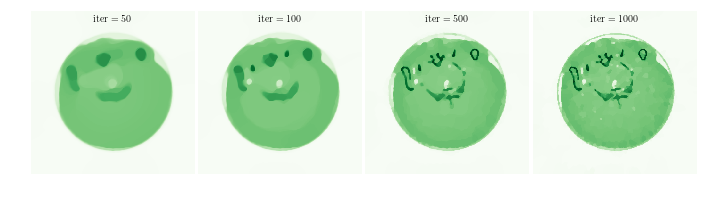

In [7]:
step = 10

Nr = 1
Nc = len(fig2_iters)
fig, axs = plt.subplots(Nr, Nc, figsize=(Nc*3, Nr*3))
gs = gridspec.GridSpec(Nr, Nc)
gs.update(wspace=0, hspace=0)

for j, it in enumerate(fig2_iters):
    it_step = np.int(it/step)
    fig2_image = fig2_data[3][it_step]['image']
    
    axs[j] = plt.subplot(gs[j])
    im = axs[j].imshow(fig2_image, cmap=colormaps[energy], vmin=0.0, vmax=vmax[energy])
    axs[j].label_outer()
    axs[j].set_axis_off()
    axs[j].text(0.5, 0.93, r'$\text{{iter}}={}$'.format(it), size=10, ha='center', transform=axs[j].transAxes)
    

plt.savefig('{}/{}_bird_bregman_iterations.pdf'.format(folder_images, energy), format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.05)


## Figure 3: Bird references

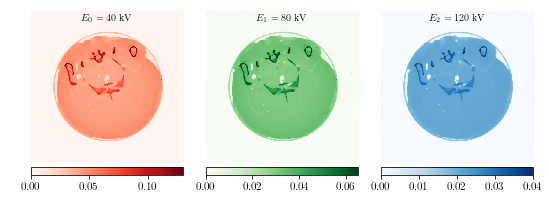

In [8]:
plt.close()
energies = ['E0', 'E1', 'E2']
full_nangles = 720

method = 'TV'
ref_alphas = {'E0': 5e-3, 'E1': 2e-3, 'E2': 2e-3}
# ref_alphas = {'E0': 0, 'E1': 0, 'E2': 0}

vmax_aux = [vmax['E0'], vmax['E1'], vmax['E2']]


Nr = 1
Nc = len(energies)
fig, axs = plt.subplots(Nr, Nc, figsize=(Nc*3, Nr*3.8))
gs = gridspec.GridSpec(Nr, Nc)
gs.update(wspace=0.15, hspace=0.05)

for j, energy in enumerate(energies):
    alpha = ref_alphas[energy]
    name = '{}_{}x{}_reference_reconstruction_a{}'.format(energy, sub_m, sub_m, a_str)
    name = name + '_alpha_' + str(alpha).replace('.', '_')
    ref_dir = '{}/{}_d{}x{}.npy'.format(folder_data, name, full_nangles, sub_ndet)
    igt = np.load(ref_dir)[0]
    
    axs[j] = plt.subplot(gs[j])
    im = axs[j].imshow(igt, cmap=colormaps[energy], vmin=0.0, vmax=vmax_aux[j])
    axs[j].label_outer()
    axs[j].set_axis_off()
    # axs[j].set_title(r'$E_{0}={1}$ KeV'.format(j, s_views[j]))
    axs[j].text(0.5, 0.93, r'$E_{0}={1}$ kV'.format(j, s_views[j]), size=10, ha='center', transform=axs[j].transAxes)
    
    fig.colorbar(im, ax=axs[j], pad=0.02, orientation="horizontal")

plt.savefig('{}/gt{}x{}_{}.pdf'.format(folder_images, n, n, dataset),
            format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.05)

## Figure 4: Side information

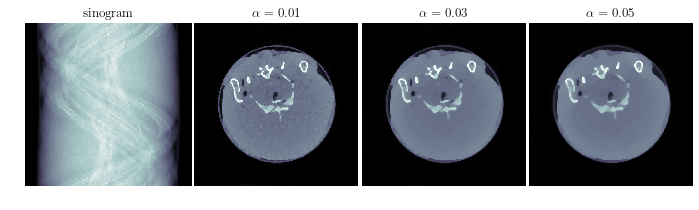

In [9]:
# SINFO AND RECONTRUCTIONS FOR DIFFERENT VALUES OF ALPHA
cmap = 'bone'
alphas = [1e-2, 3e-2, 5e-2]
labels = [r'$\alpha = 0.01$', r'$\alpha =0.03$',
          r'$\alpha =0.05$']

Nc = len(alphas) + 1
fig, axs = plt.subplots(1, Nc, figsize=(3*Nc, 3))
gs = gridspec.GridSpec(1, Nc)
gs.update(wspace=0, hspace=0)  # set the spacing between axes.

# sinogram
name = 'sinfo_sinogram_{}x{}'.format(sub_nangles, sub_ndet)
sinfo_dir = '{}/{}.npy'.format(folder_data, name)
sinfo_sino = np.load(sinfo_dir)
axs[0] = plt.subplot(gs[0])
im = axs[0].imshow(sinfo_sino, cmap=cmap, vmin=0, vmax=6, aspect=6)
axs[0].label_outer()
axs[0].set_axis_off()
axs[0].set_title('sinogram')

# TV sinfo alpha= 1e-3
alpha = alphas[0]
sinfo_name = 'TV_reconstruction_{}'.format(str(alpha).replace('.', '_'))
name = 'sinfo_{}_d{}x{}_m{}_a{}'.format(sinfo_name, sub_nangles,
                                        sub_ndet, sub_m, a_str)
sinfo_file = '{}/{}.npy'.format(folder_data, name)
sinfo_TV1 = np.load(sinfo_file)
axs[1] = plt.subplot(gs[1])
im = axs[1].imshow(sinfo_TV1, cmap=cmap, vmin=0, vmax=vmax_sinfo)
axs[1].label_outer()
axs[1].set_axis_off()
axs[1].set_title(labels[0])

alpha = alphas[1]
sinfo_name = 'TV_reconstruction_{}'.format(str(alpha).replace('.', '_'))
name = 'sinfo_{}_d{}x{}_m{}_a{}'.format(sinfo_name, sub_nangles,
                                        sub_ndet, sub_m, a_str)
sinfo_file = '{}/{}.npy'.format(folder_data, name)
sinfo_TV1 = np.load(sinfo_file)
axs[2] = plt.subplot(gs[2])
im = axs[2].imshow(sinfo_TV1, cmap=cmap, vmin=0, vmax=vmax_sinfo)
axs[2].label_outer()
axs[2].set_axis_off()
axs[2].set_title(labels[1])

# TV sinfo alpha= 2e-3
alpha = alphas[2]
sinfo_name = 'TV_reconstruction_{}'.format(str(alpha).replace('.', '_'))
name = 'sinfo_{}_d{}x{}_m{}_a{}'.format(sinfo_name, sub_nangles,
                                        sub_ndet, sub_m, a_str)
sinfo_file = '{}/{}.npy'.format(folder_data, name)
sinfo_TV1 = np.load(sinfo_file)
axs[3] = plt.subplot(gs[3])
im = axs[3].imshow(sinfo_TV1, cmap=cmap, vmin=0, vmax=vmax_sinfo)
axs[3].label_outer()
axs[3].set_axis_off()
axs[3].set_title(labels[2])

name = 'sinfo_reconstructions_d{}x{}'.format(sub_nangles, sub_ndet)
plt.savefig('{}/{}.pdf'.format(folder_images, name), format='pdf',
            dpi=1000, bbox_inches='tight', pad_inches=0.05)

# FBS reconstructions

In [10]:
alg = 'fbs'
tol = 1e-5
sinfo_type = '0_03'
sinfo_label = r'0.03'
eta_str = '1.0e_02'

## E0 reconstruction for three different values of $\alpha$

In [11]:
energies = ['E0', 'E1', 'E2']

regs = ['TV', 'dTV']

gt = {}
for energy in energies:
    gt_name = '{}/{}_{}x{}_reference_reconstruction_a{}'.format(folder_data, energy, n, n, a_str)
    gt_name = '{}_alpha_{}'.format(gt_name, str(ref_alphas[energy]).replace('.', '_'))
    gt_name = '{}_d{}x{}.npy'.format(gt_name, 720, sub_ndet)
    gt_aux = np.load(gt_name)
    gt[energy] = U.element(gt_aux[0])

In [12]:
alphas = {'E0': {'TV': [1e-2, 2.5e-2, 5e-2],
                 'dTV': [1e-2, 2.5e-2, 5e-2]},
          'E1': {'TV': [1e-3, 5e-3, 1e-2],
                 'dTV': [5e-3, 1e-2, 5e-2]},
          'E2': {'TV': [1e-3, 5e-3, 1e-2],
                 'dTV': [5e-3, 1e-2, 5e-2]}}

final_image = {}
final_iter = {}
final_ssim = {}
final_value = {}
final_hpsi = {}
final_psnr = {}

for energy in energies:
    
    cmap = colormaps[energy]
    groundtruth = gt[energy]
    
    final_image[energy] = {}
    final_iter[energy] = {}
    final_ssim[energy] = {}
    final_hpsi[energy] = {}
    final_psnr[energy] = {}
    final_value[energy] = {}
    
    for reg in regs:
        
        final_image[energy][reg] = {}
        final_iter[energy][reg] = {}
        final_ssim[energy][reg] = {}
        final_hpsi[energy][reg] = {}
        final_psnr[energy][reg] = {}
        final_value[energy][reg] = {}
        
        iter_save_v, niter_v, image_v, out_v, nsub_v = {}, {}, {}, {}, {}

        for j in range(3):
            
            alpha = ('{0:.1e}'.format(alphas[energy][reg][j])).replace('-', '_')
            # # Distinguir entre TV y dTV con side info en el nombre
            if reg == 'TV':
                fn = '{}/{}_{}{}_alpha_{}_tol_{}'\
                     '_output.npy'.format(folder_npy, energy, alg, reg, alpha,
                                          str(tol).replace('-', '_'))
            elif reg == 'dTV':
                fn = '{}/{}_{}{}_alpha_{}_tol_{}_sinfo_{}_eta_{}'\
                     '_output.npy'.format(folder_npy, energy, alg, reg, alpha,
                                          str(tol).replace('-', '_'),
                                          sinfo_type, eta_str)

            (iter_save_v[fn], niter_v[fn], image_v[fn], out_v[fn],
             nsub_v[fn]) = np.load('{}'.format(fn))

            final_image[energy][reg][alpha] = image_v[fn]
            final_iter[energy][reg][alpha] = out_v[fn][-1]['iter']
            data = final_image[energy][reg][alpha]
            final_ssim[energy][reg][alpha] = ssim(data, groundtruth)
            final_hpsi[energy][reg][alpha] = hpsi(data, groundtruth)
            final_psnr[energy][reg][alpha] = psnr(data, groundtruth)
            # final_ssim[alpha][energy][reg] = out_v[fn][-1]['ssim_u']
            # final_hpsi[alpha][energy][reg] = out_v[fn][-1]['hpsi_u']
            # final_psnr[alpha][energy][reg] = out_v[fn][-1]['psnr_u']

            final_value[energy][reg][alpha] = out_v[fn][-1]['obj']

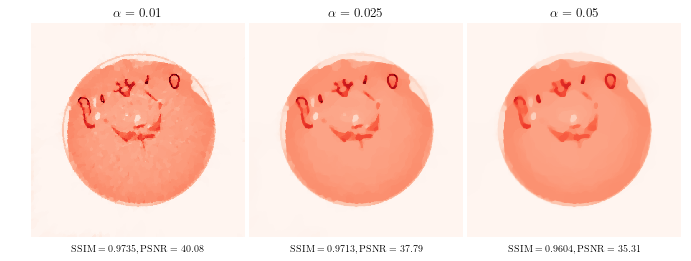

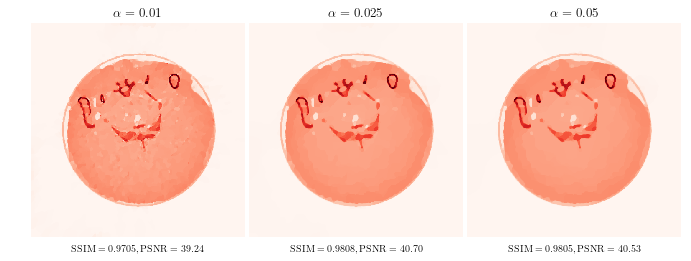

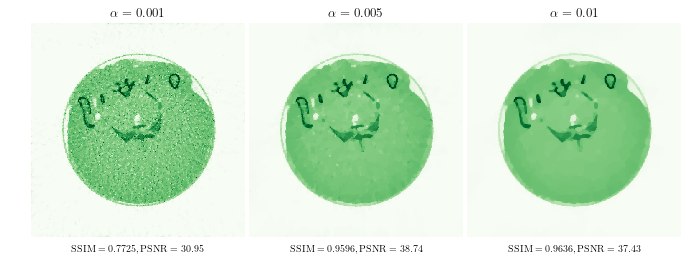

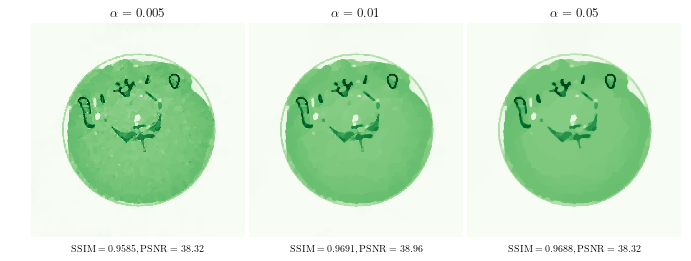

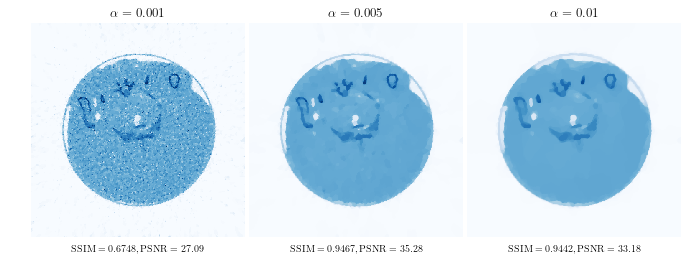

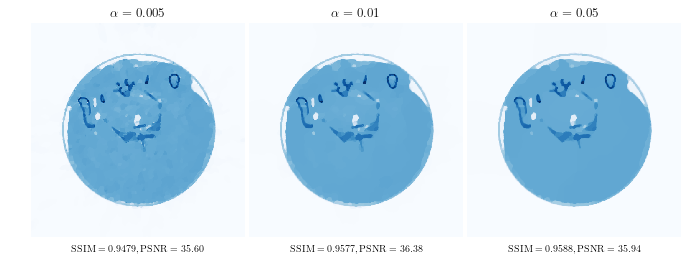

In [13]:
# SSIM and PSNR plots (THREE ALPHAS VS ENERGY FOR TV AND DTV)
# Block 3.2
energies = ['E0', 'E1', 'E2']
regs = ['TV', 'dTV']
for energy in energies:
    cmap = colormaps[energy]
    for reg in regs:
        alphas_local = alphas[energy][reg]
        Nc = len(alphas_local)
        fig, axs = plt.subplots(1, Nc, figsize=(3*Nc, Nc))
        gs = gridspec.GridSpec(1, Nc)
        gs.update(wspace=0, hspace=0)  # set the spacing between axes.

        for j, alpha_val in enumerate(alphas_local):
            
            alpha = ('{0:.1e}'.format(alpha_val)).replace('-', '_')
            # print(reg + ' ' + alpha)

            selected_image = final_image[energy][reg][alpha]
            axs[j] = plt.subplot(gs[j])
            im = axs[j].imshow(selected_image, cmap=cmap, vmin=0,
                           vmax=vmax[energy])
            axs[j].label_outer()
            axs[j].set_axis_off()
            axs[j].set_title(r'$\alpha = {}$'.format(alpha_val))
            ssim_val = final_ssim[energy][reg][alpha]
            psnr_val = final_psnr[energy][reg][alpha]
            hpsi_val = final_hpsi[energy][reg][alpha]
            axs[j].text(0.5, -0.07,
                        r'$\text{{SSIM}}={0:.4f}, \text{{PSNR}}={1:.2f}$'
                        .format(ssim_val, psnr_val), size=10, ha='center',
                        transform=axs[j].transAxes)
            plt.subplots_adjust(top=0.99, bottom=0, right=1.01, left=0,
                                hspace=0.1, wspace=0.1)

        name = '{}_{}_alphas_eta_{}'.format(energy, reg, eta_str)
        plt.savefig('{}/{}.pdf'.format(fig_folder, name), format='pdf',
                    dpi=1000, bbox_inches='tight', pad_inches=0.05)

# Figure 5: Best $\alpha$ for each energy in TV and dTV

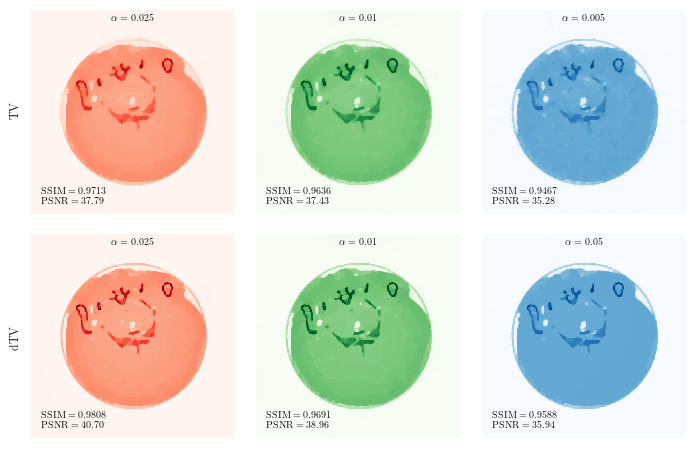

In [14]:
Nc = 3
Nr = 2

fig, axs = plt.subplots(Nr, Nc, figsize=(Nc*3.1, Nr*3))
gs = gridspec.GridSpec(Nr, Nc)
gs.update(wspace=0, hspace=0.1)  # set the spacing between axes.

best_alphas = {}
for k, energy in enumerate(energies):
    cmap = colormaps[energy]
    best_alphas[energy] = {}
    
    for j, reg in enumerate(regs):
        
        alpha_val = optimal_alphas[energy][reg]
        best_alphas[energy][reg] = alpha_val
        alpha = ('{0:.1e}'.format(alpha_val)).replace('-', '_')
        image = final_image[energy][reg][alpha]
        
        axs[j, k] = plt.subplot(gs[j, k])
        im = axs[j, k].imshow(image, cmap=cmap, vmax=vmax[energy], vmin=0)
        axs[j, k].label_outer()
        axs[j, k].set_axis_off()
        ssim_val = final_ssim[energy][reg][alpha]
        psnr_val = final_psnr[energy][reg][alpha]
        
        axs[j, k].text(0.5, 0.95, r'$\alpha={}$'.format(alpha_val), size=10, ha='center', transform=axs[j, k].transAxes)
        axs[j, k].text(0.05, 0.1, r'$\text{{SSIM}}={0:.4f}$'.format(ssim_val), size=10, ha='left', transform=axs[j, k].transAxes)
        axs[j, k].text(0.05, 0.05, r'$\text{{PSNR}}={0:.2f}$'.format(psnr_val), size=10, ha='left', transform=axs[j, k].transAxes)
        plt.subplots_adjust(top=0.99, bottom=0, right=1.01, left=0, hspace=0.1, wspace=0.1)
        if k==0:
            axs[j, k].text(-0.08, 0.5, r'{}'.format(reg), size=12, ha='center', rotation=90,
                            transform=axs[j, k].transAxes) 

name = 'all_energies_fbs_TV_dTV_{}x{}_eta{}_tol_{}'.format(m[0], m[1], eta_str, tol)
plt.savefig('{}/{}.pdf'.format(fig_folder, name), format='pdf',
             dpi=1000, bbox_inches='tight', pad_inches=0)

# BREGMAN RESULTS

In [15]:
alg = 'bregman'
alpha_val = 1e1
bregman_alpha = '{0:.1e}'.format(alpha_val).replace('-', '_')
sinfo_type = '0_03'

## Figure 6: Iterations vs SSIM values

In [16]:
regs = ['TV', 'dTV']
energies = ['E0', 'E1', 'E2']
file_names = {}
for energy in energies: 
    file_names[energy] = {}
    
    iter_save_v, niter_v, image_v, out_v, nsub_v = {}, {}, {}, {}, {}
    
    for reg in regs:
        if reg == 'TV':
            fn = '{}/{}_{}{}_alpha_{}_tol_{}'\
                 '_output.npy'.format(folder_npy, energy, alg, reg, bregman_alpha,
                                      str(tol).replace('-', '_'))
        elif reg == 'dTV':
            fn = '{}/{}_{}{}_alpha_{}_tol_{}_sinfo_{}_eta_{}'\
                 '_output.npy'.format(folder_npy, energy, alg, reg, bregman_alpha,
                                      str(tol).replace('-', '_'),
                                      sinfo_type, eta_str)
        file_names[energy][reg] = fn
        # print(fn)

        (iter_save_v[fn], niter_v[fn], image_v[fn], out_v[fn], nsub_v[fn]) = np.load('{}'.format(fn))

# Read files
out_resorted_im = {}
out_resorted_sim = {}
meas = 'image'
sim_measures = ['ssim_u', 'psnr_u']
    
for energy in energies:
    igt = gt[energy]
    for reg in regs:
        fn = file_names[energy][reg]
        (iter_save_v[fn], niter_v[fn], image_v[fn], out_v[fn], nsub_v[fn]) = np.load('{}'.format(fn))
        out_fn = out_v[fn]
        out_resorted_im[fn] = {}
        K = len(iter_save_v[fn])
        for k in range(K):
            out_resorted_im[fn][k] = out_v[fn][k]['image']

        out_resorted_sim[fn] = {}

        for meas in sim_measures:
            print(meas + ' ' + energy + ' ' + reg)
            out_resorted_sim[fn][meas] = 0 * np.ones(K)
            for k in range(K):
                if meas == 'ssim_u':
                    out_resorted_sim[fn][meas][k] = ssim(out_fn[k]['image'], igt)
                if meas == 'psnr_u':
                    out_resorted_sim[fn][meas][k] = psnr(out_fn[k]['image'], igt)

./results_npy/bird_data/d90x552_gt512_u512/npy/E0_bregmanTV_alpha_1.0e+01_tol_1e_05_output.npy
./results_npy/bird_data/d90x552_gt512_u512/npy/E0_bregmandTV_alpha_1.0e+01_tol_1e_05_sinfo_0_03_eta_1.0e_02_output.npy
./results_npy/bird_data/d90x552_gt512_u512/npy/E1_bregmanTV_alpha_1.0e+01_tol_1e_05_output.npy
./results_npy/bird_data/d90x552_gt512_u512/npy/E1_bregmandTV_alpha_1.0e+01_tol_1e_05_sinfo_0_03_eta_1.0e_02_output.npy
./results_npy/bird_data/d90x552_gt512_u512/npy/E2_bregmanTV_alpha_1.0e+01_tol_1e_05_output.npy
./results_npy/bird_data/d90x552_gt512_u512/npy/E2_bregmandTV_alpha_1.0e+01_tol_1e_05_sinfo_0_03_eta_1.0e_02_output.npy
ssim_u E0 TV
psnr_u E0 TV
ssim_u E0 dTV
psnr_u E0 dTV
ssim_u E1 TV
psnr_u E1 TV
ssim_u E1 dTV
psnr_u E1 dTV
ssim_u E2 TV
psnr_u E2 TV
ssim_u E2 dTV
psnr_u E2 dTV


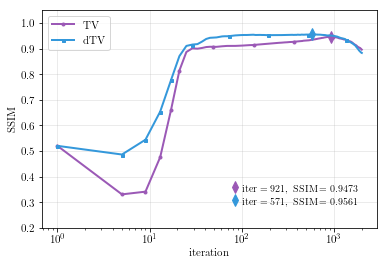

In [17]:
# %% Plot SSIM and PSNR values along iterations (curves)
# Block 4.3
step = 10
# Vectorized SSIM and PSNR
vect_sim = {}

for energy in energies:
    vect_sim[energy] = {}
    for reg in regs:
        fn = file_names[energy][reg]
        vect_sim[energy][reg] = {}
        label = [r'{}'.format(reg) for reg in regs]
        meas_names = [r'SSIM $[\ \%\ ]$', 'PSNR [dB]']

        for meas in sim_measures:
            vect_sim[energy][reg][meas] =  0 * np.ones(K)
            
            for k in range(K):
                vect_sim[energy][reg][meas][k] = out_resorted_sim[fn][meas][k]

max_SSIM = {}
for energy in energies:
    max_SSIM[energy] = {}
    # Plot
    x = np.arange(1, step*K + 1, step)
    k = 0
    
    plt.clf()
    plt.close()
    
    for i, reg in enumerate(regs):
        
        y = vect_sim[energy][reg]['ssim_u']
        ind_max = np.argmax(y)
        max_x = x[ind_max] 
        max_y = y[ind_max]
        
        xnew = np.linspace(1, step*(K-1)+1, num=500, endpoint=True)
        f2 = interp1d(x, y, kind='cubic')
        
        # plt.semilogx(xnew, f2(xnew)
        plt.semilogx(xnew, f2(xnew), color=color_set[k], linestyle=lstyle,
                     linewidth=2, marker=marker[k], markersize=3,
                     label=label[k], markevery=.1)
        
        max_SSIM[energy][reg] = np.argmax(y)
        plt.plot(max_x, max_y, 'p', color=color_set[k], markersize=8, marker='d')

        plt.plot(85, 0.36-i*0.05, 'p', color=color_set[k], markersize=8, marker='d')
        plt.text(100, 0.34-i*0.05, r'$\text{{iter}}={:4g},\ \text{{SSIM}}={:.4g}$'.format(max_x, max_y),
                 fontsize=10)
        # plt.xticks([1, 10, 50, 100, 300, 500, 1000],
        #            [1, 10, 50, 100, 300, 500, 1000])
        plt.grid(True, alpha=0.3)
        plt.gca().set_xlabel('iteration')
        plt.gca().set_ylabel(r'SSIM')
        plt.legend(frameon=True, loc='best', ncol=1)
        k += 1

    axes = plt.gca()
    axes.set_ylim([0.2, 1.05])

    name = '{}_{}_iter_vs_SSIM_eta_{}_tol_{}_alpha_'\
           '{}'.format(energy, alg, eta_str, tol, bregman_alpha)
    plt.savefig('{}/{}.pdf'.format(fig_folder, name), format='pdf',
                dpi=1000, bbox_inches='tight', pad_inches=0)

{'E2': {'dTV': 57, 'TV': 92}, 'E0': {'dTV': 15, 'TV': 50}, 'E1': {'dTV': 21, 'TV': 90}}


<Figure size 432x288 with 0 Axes>

<Figure size 648x216 with 0 Axes>

<Figure size 648x216 with 0 Axes>

<Figure size 648x216 with 0 Axes>

<Figure size 648x216 with 0 Axes>

<Figure size 648x216 with 0 Axes>

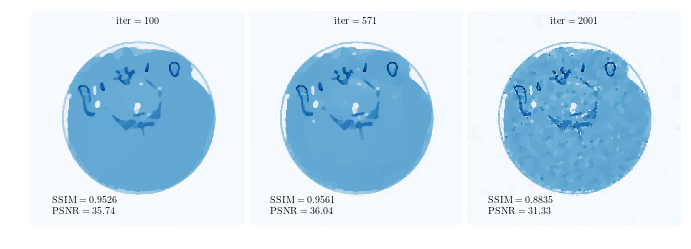

In [18]:
# %% SSIM and PSNR with IMAGES for given iterations y given reg (3 images)
# Block 4.4
print(max_SSIM)
bregman_images = {}
alg = 'bregman'

for energy in energies:
    cmap = colormaps[energy]
    bregman_images[energy] = {}
    for reg in regs:
        
        fn = file_names[energy][reg]
        iters = [99, max_SSIM[energy][reg]*step, step*(K-1)]
        plt.clf()
        Nc = len(iters)
        fig, axs = plt.subplots(1, Nc, figsize=(3*Nc, Nc))
        gs = gridspec.GridSpec(1, Nc)
        gs.update(wspace=0, hspace=0)  # set the spacing between axes.

        if reg == 'TV':
            fn = '{}/{}_{}{}_alpha_{}_tol_{}'\
                 '_output.npy'.format(folder_npy, energy, alg, reg, bregman_alpha,
                                      str(tol).replace('-', '_'))
        elif reg == 'dTV':
            fn = '{}/{}_{}{}_alpha_{}_tol_{}_sinfo_{}_eta_{}'\
                 '_output.npy'.format(folder_npy, energy, alg, reg, bregman_alpha,
                                      str(tol).replace('-', '_'),
                                      sinfo_type, eta_str)

        for j, iter_val in enumerate(iters):
            sub_val = int(iter_val/step)
            selected_image = out_resorted_im[fn][sub_val]
            axs[j] = plt.subplot(gs[j])
            im = axs[j].imshow(selected_image, cmap=cmap, vmin=0,
                               vmax=vmax[energy])
            axs[j].label_outer()
            axs[j].set_axis_off()
            ssim_val = out_resorted_sim[fn]['ssim_u'][sub_val]
            psnr_val = out_resorted_sim[fn]['psnr_u'][sub_val]

            axs[j].text(0.5, 0.94, r'$\text{{iter}} = {}$'.format(iter_val + 1), size=10, ha='center',
                        transform=axs[j].transAxes)
            axs[j].text(0.1, 0.1, r'$\text{{SSIM}}={0:.4f}$'.format(ssim_val), size=10, ha='left',
                        transform=axs[j].transAxes)
            axs[j].text(0.1, 0.05, r'$\text{{PSNR}}={0:.2f}$'.format(psnr_val), size=10, ha='left',
                        transform=axs[j].transAxes)

            plt.subplots_adjust(top=0.99, bottom=0, right=1.01, left=0,
                                hspace=0.1, wspace=0.1)
            if j == 1:
                bregman_images[energy][reg] = selected_image

        name = '{}_{}{}_images_iter_eta_{}_alpha_'\
               '{}'.format(energy, alg, reg, eta_str, bregman_alpha)
        plt.savefig('{}/{}.pdf'.format(fig_folder, name), format='pdf',
                    dpi=1000, bbox_inches='tight', pad_inches=0)

## Figure 7: Bregman best iterations for all energies

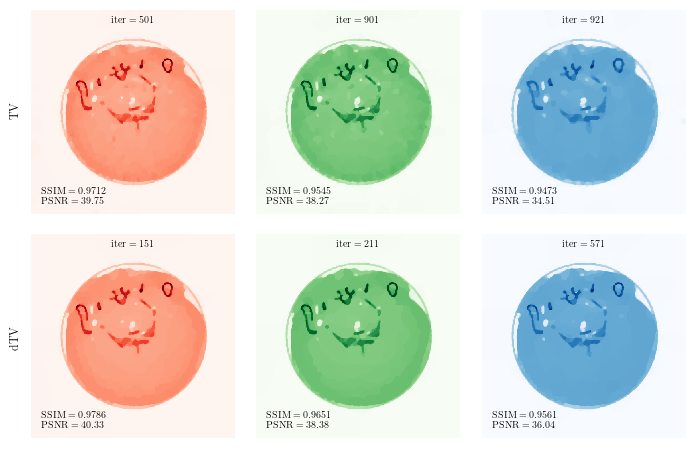

In [19]:
Nc = 3
Nr = 2

alg = 'bregman'
energies = ['E0', 'E1', 'E2']
regs = ['TV', 'dTV']

fig, axs = plt.subplots(Nr, Nc, figsize=(Nc*3.1, Nr*3))
gs = gridspec.GridSpec(Nr, Nc)
gs.update(wspace=0, hspace=0.1)  # set the spacing between axes.

best_alphas = {}
for k, energy in enumerate(energies):
    cmap = colormaps[energy]
    best_alphas[energy] = {}
    
    for j, reg in enumerate(regs):
        
        if reg == 'TV':
            fn = '{}/{}_{}{}_alpha_{}_tol_{}'\
                 '_output.npy'.format(folder_npy, energy, alg, reg, bregman_alpha,
                                      str(tol).replace('-', '_'))
        elif reg == 'dTV':
            fn = '{}/{}_{}{}_alpha_{}_tol_{}_sinfo_{}_eta_{}'\
                 '_output.npy'.format(folder_npy, energy, alg, reg, bregman_alpha,
                                      str(tol).replace('-', '_'),
                                      sinfo_type, eta_str)
    
        sub_val = max_SSIM[energy][reg]
        image = out_resorted_im[fn][sub_val]
        
        axs[j, k] = plt.subplot(gs[j, k])
        im = axs[j, k].imshow(image, cmap=cmap, vmax=vmax[energy], vmin=0)
        axs[j, k].label_outer()
        axs[j, k].set_axis_off()
        ssim_val = out_resorted_sim[fn]['ssim_u'][sub_val]
        psnr_val = out_resorted_sim[fn]['psnr_u'][sub_val]
        
        axs[j, k].text(0.5, 0.94, r'$\text{{iter}} = {}$'.format(sub_val*step + 1), size=10, ha='center', transform=axs[j, k].transAxes)
        axs[j, k].text(0.05, 0.1, r'$\text{{SSIM}}={0:.4f}$'.format(ssim_val), size=10, ha='left', transform=axs[j, k].transAxes)
        axs[j, k].text(0.05, 0.05, r'$\text{{PSNR}}={0:.2f}$'.format(psnr_val), size=10, ha='left', transform=axs[j, k].transAxes)
        plt.subplots_adjust(top=0.99, bottom=0, right=1.01, left=0, hspace=0.1, wspace=0.1)
        if k==0:
            axs[j, k].text(-0.08, 0.5, r'{}'.format(reg), size=12, ha='center', rotation=90,
                            transform=axs[j, k].transAxes) 

name = 'all_energies_bregman_TV_dTV_{}x{}_eta{}_tol_{}'.format(m[0], m[1], eta_str, tol)
plt.savefig('{}/{}.pdf'.format(fig_folder, name), format='pdf',
             dpi=1000, bbox_inches='tight', pad_inches=0)

## Figure 8: FBS vs Bregman with difference image (all energies)

<Figure size 432x288 with 0 Axes>

<Figure size 878.4x432 with 0 Axes>

<Figure size 878.4x432 with 0 Axes>

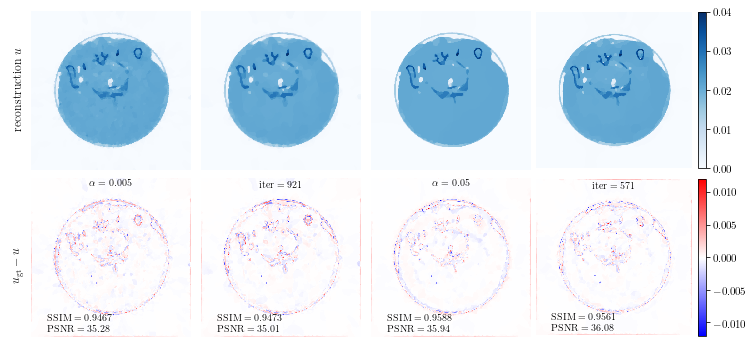

In [20]:
# %% BREGMAN VS FBS
a1, a2 = (360, 276)
step = 10
algorithms = ['FBS', 'Bregman'] 
cmap_diff = 'bwr'
vmax_diff = {'E0': 0.06, 'E1': 0.03, 'E2': 0.012}

for energy in energies:
    
    ref_energy = gt[energy]
    cmap = colormaps[energy]
    
    plt.clf()
    Nc = 4
    Nf = 2

    fig, axs = plt.subplots(Nf, Nc, figsize=(Nc*3.05, Nf*3))
    gs = gridspec.GridSpec(Nf, Nc)
    gs.update(wspace=0, hspace=0.05)  # set the spacing between axes.

    for i, reg in enumerate(regs):
        
        fbs_alpha = optimal_alphas[energy][reg]
        fn = file_names[energy][reg]
        bregman_iter = max_SSIM[energy][reg]*step
        
        for ll, alg in enumerate(algorithms):
            j = 0
            k = 0 + ll + 2*i
            
            if alg == 'FBS':
                alpha_aux = ('{0:.1e}'.format(fbs_alpha)).replace('-', '_')
                selected_image = final_image[energy][reg][alpha_aux]
                axs[j, k].text(0.5, 0.94, r'$\text{{iter}} = {}$'.format(optimal_labels[energy][reg]), size=10, ha='center',
                               transform=axs[j, k].transAxes)
                ssim_val = final_ssim[energy][reg][alpha_aux]
                psnr_val = round(final_psnr[energy][reg][alpha_aux], 2)
                
            elif alg == 'Bregman':
                selected_image = bregman_images[energy][reg]
                axs[j, k].text(0.5, 0.94, r'$\text{{iter}} = {}$'.format(bregman_iter + 1), size=10, ha='center',
                               transform=axs[j, k].transAxes)
                
                sub_val = int(bregman_iter/step)
                ssim_val = np.max(out_resorted_sim[fn]['ssim_u'])
                psnr_val = np.max(out_resorted_sim[fn]['psnr_u'])

                   
            axs[j, k] = plt.subplot(gs[j, k])
            im = axs[j, k].imshow(selected_image, cmap=cmap, vmax=vmax[energy], vmin=0)
            axs[j, k].label_outer()
            axs[j, k].set_axis_off()
            if energy == 'E0':
                axs[j, k].set_title('{}, {}'.format(alg, reg))
            if j == 0:
                if k==3:
                    plt.colorbar(im, ax=axs[j, k], pad=0.04, fraction=0.046)
                    
                if k==0:
                    axs[j, k].text(-0.08, 0.7, r'reconstruction $u$', size=12, ha='center', rotation=90,
                                   transform=axs[j, k].transAxes) 
            
            j = 1
            k = 0 + ll + 2*i
            diff = ref_energy - selected_image
            axs[j, k] = plt.subplot(gs[j, k])
            im = axs[j, k].imshow(diff, cmap=cmap_diff, vmin=-vmax_diff[energy], vmax=vmax_diff[energy])
            axs[j, k].label_outer()
            axs[j, k].set_axis_off()
            if alg == 'FBS':
                axs[j, k].text(0.5, 0.95, r'$\alpha={}$'.format(optimal_labels[energy][reg]), size=10, ha='center', 
                               transform=axs[j, k].transAxes)
            elif alg == 'Bregman':
                axs[j, k].text(0.5, 0.94, r'$\text{{iter}} = {}$'.format(bregman_iter + 1), size=10, ha='center',
                               transform=axs[j, k].transAxes)
            axs[j, k].text(0.1, 0.1, r'$\text{{SSIM}}={0:.4f}$'.format(ssim_val), size=10, ha='left',
                           transform=axs[j, k].transAxes)
            axs[j, k].text(0.1, 0.03, r'$\text{{PSNR}}={0:.2f}$'.format(psnr_val), size=10, ha='left',
                           transform=axs[j, k].transAxes)
            if j == 1:
                if k==3:
                    plt.colorbar(im, ax=axs[j, k], pad=0.04, fraction=0.046)
            
                if k==0:
                    axs[j, k].text(-0.08, 0.5, r'$u_{\text{gt}} - u$', size=12, ha='center', rotation=90,
                                   transform=axs[j, k].transAxes) 
    
    name = '{}_fbs_vs_bregman_TV_dTV_differences_d{}x{}_eta{}_tol_{}_alpha_'\
           '{}'.format(energy, sub_nangles, sub_ndet, eta_str, tol, bregman_alpha)
    plt.savefig('{}/{}.pdf'.format(fig_folder, name), format='pdf',
                dpi=1000, bbox_inches='tight', pad_inches=0)